In [1]:
import sys

sys.path.append("..")
import jabble.model
import jabble.dataset
import jabble.loss
import jabble.physics 
import astropy.units as u
import astropy.time as atime

import h5py
import matplotlib.pyplot as plt
import scipy.optimize

from jaxopt import GaussNewton
import jax.numpy as jnp
import jax
import numpy as np
from mpl_axes_aligner import align
import os
import jabble.physics

from astropy.io import fits
import pathlib
from collections import defaultdict

import jax.config

jax.config.update("jax_enable_x64", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [2]:
import os
import datetime

today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
# targ_vel = np.array(file_b['pipeline_rvs'])
# targ_err = np.array(file_b['pipeline_sigmas'])
# mjds = np.array(file_b['dates'])
cache_path = pathlib.Path("/scratch/mdd423/wobble_jax/data/apogee")

In [4]:
def load_apVisit(visit):
#         root_path = f"sas/dr17/apogee/spectro/redux/dr17/visit/"

    if visit['TELESCOPE'] == 'apo25m':
        sorp = 'p'
    elif visit['TELESCOPE'] == 'lco25m':
        sorp = 's'
    else:
        raise NotImplementedError()

    sub_path = (f"{visit['TELESCOPE']}/" +
                f"{visit['FIELD'].strip()}/" +
                f"{int(visit['PLATE']):04d}/" +
                f"{int(visit['MJD']):05d}/")
    filename = (f"a{sorp}Visit-dr17-{int(visit['PLATE']):04d}-" +
                f"{int(visit['MJD']):05d}-" +
                f"{int(visit['FIBERID']):03d}.fits")
    local_path = cache_path / visit['APOGEE_ID']
    local_path.mkdir(exist_ok=True, parents=True)

    local_file = local_path / filename

    hdul = fits.open(local_file)
    return hdul
    
def load_apCframes(visit):
    # root_path = f"sas/dr17/apogee/spectro/redux/dr17/visit/"

    if visit['TELESCOPE'] == 'apo25m':
        sorp = 'p'
    elif visit['TELESCOPE'] == 'lco25m':
        sorp = 's'
    else:
        raise NotImplementedError()

    sub_path = (f"{visit['TELESCOPE']}/" +
                f"{visit['FIELD'].strip()}/" +
                f"{int(visit['PLATE']):04d}/" +
                f"{int(visit['MJD']):05d}/")

    visit_hdul = load_apVisit(visit)
    frames = [int(visit_hdul[0].header[k]) for k in visit_hdul[0].header.keys()
              if k.startswith('FRAME')]

    if len(frames) <= 1:
        return None

    hduls = defaultdict(dict)
    for frame in frames:
        for chip in ['a', 'b', 'c']:
            filename = f'a{sorp}Cframe-{chip}-{frame:08d}.fits'

            local_path = (cache_path /
                          f"{int(visit['PLATE']):04d}" /
                          f"{int(visit['MJD']):05d}/")
            local_path.mkdir(exist_ok=True, parents=True)

            local_file = local_path / filename
            hduls[frame][chip] = fits.open(local_file)

    return hduls
            
def extract_dataset(apogee_id):
    
    visits = allvisits[1].data[allvisits[1].data["APOGEE_ID"] == apogee_id]
    
    fluxes = []
    info = []
    masks = []
    waves = []
    times = []
    
    for visit in visits:
        apvisitframe = load_apVisit(visit)
        apcframes    = load_apCframes(visit)
        
        targ_id = apvisitframe[0].header['OBJID']
        
#         print(apcframes)
        # print(apcframes.keys())
        count = 0
        nidiver_ratio = 0.0
        fluxl_ratio = 0.0
        fluxn_ratio = 0.0
        errl_ratio  = 0.0
        errn_ratio  = 0.0
        waven_ratio = 0.0
        for key in apcframes.keys():
            subframe_images = apcframes[key]
            for subkey in subframe_images.keys():
                subframe = subframe_images[subkey]
                fiber_id = np.array(subframe[11].data['FIBERID'])[np.where(targ_id == np.array(subframe[11].data['OBJECT']))]

                flux = np.array(subframe[1].data)[fiber_id,:].flatten()
                wave = np.array(subframe[4].data)[fiber_id,:].flatten()
                err  = np.array(np.array(subframe[2].data)[fiber_id,:]).flatten()

                # print(flux.shape)
                mask_1 = np.array(subframe[3].data,dtype=bool)[fiber_id,:].flatten()
                # print(subframe[3].header)
                mask_1 = ~((16639 & mask_1) == 0)
            
                # print(np.stack(np.unique(subframe[3].data,return_counts=True)))
                
                mask_2 = flux <= 0.0
                mask_3 = err <= 0.0
                mask_4 = np.isnan(flux)
                mask_5 = np.isnan(wave)
                mask_6 = np.isnan(err)

                nidiver_ratio += np.sum(mask_1)/len(mask_1)
                fluxl_ratio += np.sum(mask_2)/len(mask_2)
                fluxn_ratio += np.sum(mask_4)/len(mask_4)
                errl_ratio  += np.sum(mask_3)/len(mask_3)
                errn_ratio  += np.sum(mask_6)/len(mask_6)
                waven_ratio += np.sum(mask_5)/len(mask_5)
                count += 1
                # print("nidiver: ", np.sum(mask_1))
                # print("flux<0: ",np.sum(mask_2))
                # print("err<0: ",np.sum(mask_3))
                # print("flux nan: ", np.sum(mask_4))
                # print("wave nan: ",np.sum(mask_5))
                # print("err nan: ",np.sum(mask_6))
                mask_full = (mask_1 + mask_2 + mask_3).astype(bool) #+ mask_4 + mask_5 + mask_6).astype(bool)
                
                masks.append(mask_full)
                # print(jnp.sum(masks[-1]))
                fluxes.append(np.log(flux).flatten())
                info.append((1/(err/flux)**2))
                waves.append(np.log(wave))

                fluxes[-1][mask_full] = 0.0
                info[-1][mask_full] = 0.0
                waves[-1][mask_full] = np.min(waves[-1])
                
                times.append(atime.Time(subframe[0].header['DATE-OBS']))
    print("nidiver: ", nidiver_ratio/count ,"flux<0: ", fluxl_ratio/count,"flux nan: ",fluxn_ratio/count,"err<0: ",\
            errl_ratio/count,"err nan: ",errn_ratio/count,"wave nan: ",waven_ratio/count)
    return jabble.dataset.Data.from_lists(waves, fluxes, info, masks), np.array(times)

In [5]:
# apogee_id = rrl[2]["APOGEE_ID"]
# visits = allvisits[1].data[allvisits[1].data["APOGEE_ID"] == apogee_id]
# apvisitframe = load_apVisit(visits[0])
# apcframes    = load_apCframes(visits[0])
# keys = apcframes.keys()
# for key in keys:
#     print(apcframes[key])
#     break

In [6]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")
loss = jabble.loss.ChiSquare()

5577 night sky line

6563 h alpha

In [7]:
allvisits = fits.open('/scratch/mdd423/wobble_jax/data/apogee/allVisit-dr17-synspec_rev1.fits')
allstar = fits.open('/scratch/mdd423/wobble_jax/data/apogee/allStar-dr17-synspec_rev1.fits')
rrl_mask = (
    ((allstar[1].data["APOGEE2_TARGET1"] & 2**24) != 0)
    & (allstar[1].data["NVISITS"] >= 5)
)
rrl = allstar[1].data[rrl_mask]
rrl_row = rrl[0]
print(rrl[0])
data, times = extract_dataset(rrl_row["APOGEE_ID"])

('apStar-dr17-2M21294994+1214069.fits', '2M21294994+1214069', 'apo25m.M15.2M21294994+1214069', 'apogee.apo25m.stars.M15.2M21294994+1214069', 'apogee.apo25m.synspec_fix.M15.2M21294994+1214069', 'apo25m', 5110, 'M15', 'none', 322.45809, 12.235254, 65.04736938624858, -27.242716050526685, 13.725, 0.024, 13.212, 0.028, 13.168, 0.032, '2MASS', 15.663768, 0.017714864, 14.391674, 0.019925185, 15.655821, 0.013340961, nan, nan, nan, nan, nan, nan, nan, nan, 13.109, 0.028, nan, nan, 1, 1, -41.1, -5.4, 'UCAC4', 0.032206826, 'SFD', 0.04865371, 0.10664513, 0, 0, -2130706432, -2147482624, 0, 0, 'APOGEE2_RRLYR,APOGEE2_CALIB_CLUSTER', 'apogee2-manga', 'cluster_gc', 9, 90.33413, 91.77281, 8388612, 'BRIGHT_NEIGHBOR,SUSPECT_ROTATION', 0, '', -109.69118, 0.61689794, 0.32791546, 4717.5566, 1.718648, -2.4349148, 0.0, 0.0, 1.8161609, 50.8843, 30.768461, 0, 1, 203.06557, 16.665833, -9999.99, 9999.99, -9999.99, 9999.99, 1745949633699053696, 0.06324207, 0.0272109, -0.6689615, 0.0274653, -3.9409459, 0.0240136, 15

/state/partition1/job-48687190/ipykernel_1046774/1871901740.py:128: RuntimeWarning: divide by zero encountered in log
  fluxes.append(np.log(flux).flatten())
/state/partition1/job-48687190/ipykernel_1046774/1871901740.py:128: RuntimeWarning: invalid value encountered in log
  fluxes.append(np.log(flux).flatten())
/state/partition1/job-48687190/ipykernel_1046774/1871901740.py:129: RuntimeWarning: divide by zero encountered in divide
  info.append((1/(err/flux)**2))


nidiver:  0.23665364583333334 flux<0:  0.021647135416666668 flux nan:  0.0 err<0:  0.0 err nan:  0.0 wave nan:  0.0


In [11]:
def make_order_plot(dataset,model_name,lmin,lmax,lrange,theory_model):
    model = jabble.model.load(model_name)
    # orders = np.unique(model.metadata["orders"])

    # for dataframe in dataset:
    #     print(np.exp(np.min(dataset.xs)))
    # model_name_b = os.path.join('..','out','24-06-11','peg51_o{}_no_norm.mdl'.format(order))
    plt_epoches = []
    temp = np.argsort(model[1][0].p)
    which_ones = [0,1,2,3,4,5,6]
    # plt_epoches = [0,1,2,3]
    # which_ones = jax.random.randint(jax.random.PRNGKey(0), shape=(3,), minval=0, maxval=len(temp), dtype=jnp.uint8)
    # for uni_order in np.unique(model.metadata["orders"]):
    #     print(uni_order)
    for iii in which_ones:
        # plt_epoches.append(temp[uni_order == model.metadata["orders"]][-1])
        plt_epoches.append(temp[iii])
    # plt_epoches = [0,1,2,3]#[*sorted_epoches[-1:],*sorted_epoches[:1]]
    
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),4),sharex=True,sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,1],dpi=200)
        
    model.fix()
    model.display()
    print(jnp.exp(jnp.min(model[0][1].xs)),jnp.exp(jnp.max(model[0][1].xs)))
    print(jnp.max(model[0][0].p),jnp.min(model[0][0].p))
    for ii, plt_epoch in enumerate(plt_epoches):
        # indices = model.metadata['mjds'] == model.metadata['mjds'][plt_epoch]
        
        xplot = np.linspace(np.log(lmin),np.log(lmax),\
                            dataset.xs[plt_epoch].shape[0]*10)
        # yplot = model[2]([],xplot,plt_epoch)
        yplot_norm_tot = model([],xplot,plt_epoch)
        yplot_norm_stel = model[0]([],xplot,plt_epoch)
        # yplot_norm_tell = model[1]([],xplot,plt_epoch)
        yplot_norm = model[1]([],xplot,plt_epoch)
        # for epoch in np.where(indices):
        yhat = model([],dataset.xs[plt_epoch][:],plt_epoch)
        yhat_norm = model[1]([],dataset.xs[plt_epoch][:],plt_epoch)
        axes[0,ii].set_xlim(xplot.min(),xplot.max())

        velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
        
        # Data
        axes[0,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhat_norm,yerr=dataset.yerr[plt_epoch][:]\
                            ,fmt='.k',zorder=100,alpha=0.1,ms=3)


        # Stellar Model        
        axes[0,ii].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Telluric Model
        # axes[0,ii].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Total
        # axes[0,ii].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Norm
        # axes[0,ii].plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        
        # Residuals
        axes[1,ii].plot(dataset.xs[plt_epoch],dataset.ys[plt_epoch] - yhat,\
                                 '.k',zorder=1,alpha=0.3,ms=3)

        axes[0,ii].set_title("$\delta \lambda = {:0.05f}, \chi^2 = {:2.2f}$".format(\
            model[0][0].p[plt_epoch]*np.exp(np.mean(model[0][1].xs)),loss([], dataset.xs[plt_epoch], dataset.ys[plt_epoch], dataset.yivar[plt_epoch], dataset.mask[plt_epoch], plt_epoch, model,).sum()
))
        axes[0,ii].set_ylim(-3,3)
        # axes[1,ii].set_ylim(-0.05,0.05)
        axes[0,ii].set_xticks([])
        axes[0,ii].set_xticks(np.log(lrange))
        axes[0,ii].set_xticklabels(['{}'.format(x) for x in lrange])

    # plt.x
    # plt.text(1, 1, 'Wavelength ($\AA$)', ha='center')
    plt_name = os.path.join(out_dir, "07-spectra_{}.png".format(os.path.split(model_name)[-1]))
    plt.savefig(plt_name,dpi=200,bbox_inches='tight')
    fig.suptitle('{}'.format(model_name))
    fig.text(0.5, 0.00, 'Wavelength $[\AA]$', ha='center')
    fig.text(0.04, 0.5, 'Normalized Flux', va='center', rotation='vertical')
    plt.show()

../out/24-07-17/apogee-2M21294994+1214069-cframe_norm_reg_zero.mdl
-AdditiveModel------------------------------------0
  0-CompositeModel-------------------------------------------------0
  0  0-ShiftingModel-----------------------------------------------0
  0  1-IrwinHallModel_vmap-----------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-NewNormalizationModel---------------------------------------0
15138.691555360097 16956.826361283853
1.3028968705599214e-05 -2.9124370194358455e-05


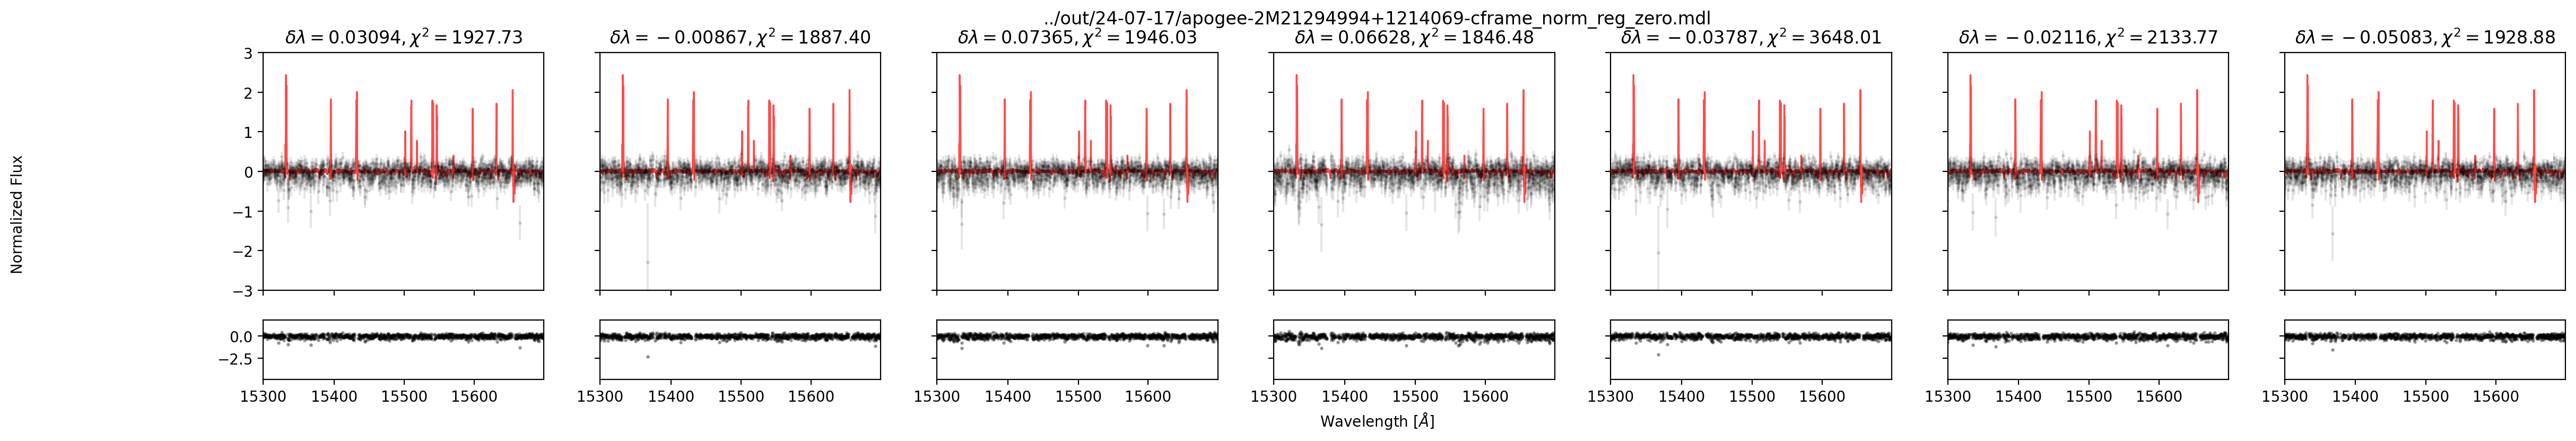

In [17]:
lmin = 15300
lmax = 15700
lspace = 100
lrange = np.arange(lmin,lmax,lspace)

plt_name= ""
model_name = os.path.join('..','out','24-07-17','apogee-{}-cframe_norm_reg_zero.mdl'.format(rrl_row["APOGEE_ID"]))
print(model_name)
# model_name_b = os.path.join('..','out','24-07-02','barnards_all_no_norm.mdl')
make_order_plot(data,model_name,lmin,lmax,lrange,None)

In [65]:
# lmin = 6360
# lmax = 6375
# lspace = 5
# lrange = np.arange(lmin,lmax,lspace)
# plt_name = os.path.join(out_dir, "02-rv_all.png")

# # model_name_p = os.path.join('..','out','24-07-01','peg51_o{}_no_norm.mdl'.format(order))
# make_order_plot(file_p,model_name_p,orders,lmin,lmax,lrange,plt_name)

In [66]:
def f_info(self,model,data,device):
        """
        Get fischer information on parameters of the model. 
        Since each parameter is independent of all other epochs, fischer information matrix is diagonal, 
        thus returns this diagonal.

        Parameters 
        ----------
        model : `jabble.Model`
            The full model to evaluate.
        data : `jabble.Dataset`
            Data to be evaluate.

        Returns
        -------
        f_info : 'jnp.array`
            (N,) array of diagonal of fischer information matrix.
        """
        f_info = np.zeros(self.n)
        model.fix()
        self.fit()
        model.display()

        # xs, ys, yivar, mask = data.blockify(device)
        # e_inds = np.arange(0,xs.shape[0],dtype=int)
        # def _internal(xs,ys,yivar,mask,e_num):
        #     duddx = jax.jacfwd(model, argnums=0)(model.get_parameters(),xs,e_num) 
        #     return jnp.sum(jnp.where(~mask,(duddx[:,e_num]**2 * yivar),0.0))
        
        # f_info = jax.vmap(_internal)(xs, ys, yivar, mask, e_inds)
            
        for e_num in range(self.n):
            # print(np.sum(data.mask[e_num][:]))
            duddx = jax.jacfwd(model, argnums=0)(model.get_parameters(),data.xs[e_num][:],e_num) 
            f_info[e_num] = jnp.sum(jnp.where(~data.mask[e_num][:],(duddx[:,e_num]**2 * data.yivar[e_num][:]),0.0))
        return f_info

In [67]:
def get_verr(self,model,data,device):
    fischer_info = f_info(self,model,data,device)

    
    dvddx = jnp.array(
        [jax.grad(jabble.physics.velocities)(x) for x in self.p]
    )
    verr = np.sqrt(1 / fischer_info) * dvddx
    vinfo = (1/verr)**2
    return verr, vinfo

In [68]:
import glob
import matplotlib.cm
import matplotlib

In [70]:
def rv_plot(model,data,verr,vinfo,targ_vel,targ_err,times,model_name,bervs):
    fig, ax = plt.subplots(
        1,
        figsize=(6, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )

    # for order in orders:
    #     data, _, _ = get_dataset(file_b,[order],cpus[0])
    #     model_name_b = os.path.join('..','out','24-05-29','barnards_o{}_no_norm.mdl'.format(order))
    #     model = jabble.model.load(model_name_b)
    # print(np.mean(verr[~np.isinf(verr)]))
    estimate_vel = jabble.physics.velocities(model[0][0].p)

    ov = (estimate_vel+bervs)
    ov -= ov.mean()
    cmap = matplotlib.colormaps["viridis"]

    # orders = np.unique(model.metadata['orders'])
    # plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(orders))))
    # for order in orders:
    #     indices = model.metadata["orders"] == order
    #     # print(indices)
    ax.errorbar(times,ov,verr,fmt='.',zorder=1,alpha=0.2,ms=2)

    # uni_times = np.unique(times)
    # ev     = jnp.zeros(len(uni_times))
    # evvar = jnp.zeros(len(uni_times))
    # for iii,time in enumerate(uni_times):
    #     indices = times == time
    ev = jnp.dot(vinfo,ov)/jnp.sum(vinfo)
    evvar (jnp.dot(vinfo,ov**2)/jnp.sum(vinfo)) - ev**2
        # print(evvar[iii],np.mean(1/vinfo[indices]))
    
    # print(np.min(ev),np.max(ev),np.mean(ev))
    ax.errorbar(uni_times,ev,jnp.sqrt(evvar),fmt='k.',zorder=1,alpha=1.0,ms=2)

    
    tv = targ_vel + bervs
    tv -= tv.mean()
    
    ax.errorbar(
        times,
        tv,
        targ_err,
        fmt=".r",
        zorder=1,
        alpha=0.5,
        ms=2,
        label='HARPS RV'
    )
    # print(np.mean(targ_vel),estimate_vel.mean())
    # print(verr.shape,ev.shape)
    
    # fig.legend()
    ax.set_ylim(-100, 100)
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "MJD")
    plt.savefig(os.path.join(out_dir, "02-{}_vel_o{}-{}.png".format(os.path.split(model_name)[-1],np.min(orders),np.max(orders))))
    plt.show()

In [71]:
# model_name_b = os.path.join('..','out','24-07-08','barnards_norm_some.mdl')
# model_name_b = os.path.join('..','out','24-07-02','barnards_all_no_norm.mdl')

model = jabble.model.load(model_name)
# orders = np.unique(model_b.metadata['orders'])
# print(orders)

# dataset_b, shifts_b, airmass_b, times_b, targ_vel, targ_err = get_dataset(file_b,cpus[0])

In [74]:
verr, vinfo = get_verr(model[0][0],model,data,cpus[0])

-AdditiveModel---------------------------------------------------240
  0-CompositeModel-----------------------------------------------240
  0  0-ShiftingModel---------------------------------------------240
  0  1-IrwinHallModel_vmap-----------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-NewNormalizationModel---------------------------------------0


In [75]:
# vinfo = 1/verr**2

In [78]:
times = np.array(times)

In [79]:
bervs = jnp.zeros()
rv_plot(model,dataset,verr,vinfo,targ_vel,targ_err,times_b,model_name_b,bervs)

NameError: name 'shifts_b' is not defined

In [ ]:
def plot_earth_residual_img(model,dataset,lrange,orders,rest_shifts,residual_resolution,plt_name):
    xrange = np.log(lrange)
    xmin, xmax = np.min(xrange), np.max(xrange)
    # xinds = ((dataset[0].xs[:] < xmax) * (dataset[0].xs[:] > xmin)).astype(bool)
    residual_img = np.zeros((len(dataset),residual_resolution))
    fig, ax = plt.subplots(2,2,figsize=(8, 8),height_ratios=[1,4],width_ratios=[4,1],sharex='col',sharey='row')
    fig.tight_layout()

    max_shift, min_shift = np.max(rest_shifts), np.min(rest_shifts)
    new_grid = np.linspace(xmin,xmax,residual_resolution)

    epsilon = np.log(np.mean(lrange) + 1) - np.log(np.mean(lrange))
    model.fix()
    model.display()
    
    for i,plt_epoch in enumerate(orders):
        
        xinds = ((dataset[plt_epoch].xs[:] <= (xmax + rest_shifts[plt_epoch] + epsilon)) * \
                 (dataset[plt_epoch].xs[:] >= (xmin + rest_shifts[plt_epoch] - epsilon))).astype(bool)
        # print(np.sum(xinds))
        residual = (dataset[plt_epoch].ys[xinds] - model([],dataset[plt_epoch].xs[xinds],plt_epoch))#*jnp.sqrt(dataset[plt_epoch].yivar[xinds])
        
        residual_img[i,:] = scipy.interpolate.interp1d(dataset[plt_epoch].xs[xinds],residual,kind='nearest')(new_grid + \
                                                                                                             rest_shifts[plt_epoch])
    
    cmap = plt.get_cmap("RdBu")

    ax[0,1].axis('off')
    ax[0,0].step(new_grid,       (residual_img**2).sum(axis=0),'k',where='mid',zorder=1,alpha=0.3,ms=3)
    ax[1,1].step((residual_img**2).sum(axis=1),np.arange(len(orders))[::-1],'k',where='post',zorder=1,alpha=0.3,ms=3)
    
    ax[1,0].set_ylim(0,np.max(orders)+1)
    ax[1,0].set_xlim(xmin,xmax)
    extent = [xmin,xmax,0,np.max(orders)+1]
    ax[1,0].imshow(residual_img,cmap=cmap,aspect="auto",vmin=-0.1,vmax=0.1,extent=extent,interpolation='nearest')
    ax[1,0].set_xlabel('Wavelength [$\AA$]')
    ax[1,0].set_ylabel('Residuals')
    # # plt.xticks([])
    ax[1,0].set_xticks(xrange)
    ax[1,0].set_xticklabels(['{}'.format(l) for l in lrange])
    # ax[1,0].get_shared_x_axes().join(ax[1,0], ax[1,1])
    # plt.xlabel()
    plt.savefig(os.path.join(out_dir, plt_name))
    plt.show()


    # worst_epochs = np.zeros(len(orders),dtype=bool)
    worst_epochs = (residual_img**2).sum(axis=1) > 0.7
    # print(worst_epochs)
    # print(orders)
    # print(orders[worst_epochs])
    return orders[worst_epochs]

In [ ]:
lmin = 6550
lmax = 6570
residual_resolution = 4096
lrange = np.linspace(lmin,lmax,5)
plt_name =  "02-barnards-res.png"

rest_vel = model_b[0][0].p
index_sort = np.argsort(rest_vel)
rest_shifts = jabble.physics.shifts(rest_vel)
plot_earth_residual_img(model_b,dataset_b,lrange,index_sort,rest_shifts,residual_resolution,plt_name)

In [22]:
from functools import partial
from jax import jit

In [23]:
@partial(jit,static_argnums=[3,4,5])
def cardinal_vmap_model(x, xp, ap, basis, a):
    """
    Evaluates cardinal basis using vmap design matrix.

    Parameters
    ----------
    x : `np.ndarray`
        array (N,) of x values to evaluate.
    xp : `np.ndarray`
        evenly spaced array (M,) of centerpoints of the basis functions
    ap : `np.ndarray`
        coefficient for basis functions
    basis : anything callable
        Basis function. Should probably make sense as a real basis function.
    a : `float`
        basis function must go to zero outside this value.
        
    Returns
    -------
    out : 'np.ndarray`
        y array (N,) of evaluated vmap cardinal basis
    """
    dx = xp[1] - xp[0]
    ap = jnp.array(ap)
    # assert np.all(dx == xp[1:] - xp[:-1])
    arange = jnp.floor(jnp.arange(-a - 1, a + 2, step=1.0)).astype(int)
    # get distance between each element and the closest cardinal basis to its left
    inputs = ((x - xp[0]) / dx) % 1
    # get index of the cardinal basis spline to datapoints left
    index = ((x - xp[0]) // dx).astype(int)

    def _internal(inputs, index):

        return jnp.dot(ap[index - arange], basis(inputs + arange))

    out = jax.vmap(_internal, in_axes=(0, 0), out_axes=0)(inputs, index)

    return out

class IrwinHallModel_vmap(jabble.model.IrwinHallModel_full):
    """
    Model that evaluates input using Irwin-Hall cardinal basis with jax.vmap.

    Parameters
    ----------
    xs : `np.ndarray`
        centerpoints of cardinal (evenly spaced) basis functions
    p_val : `int`
        order of the Irwin-Hall basis functions
    p : `np.ndarray`
        the initial control points. If None, then initialized at zero.

    """
    def call(self, p, x, *args):

        a = (self.p_val + 1) / 2
        y = cardinal_vmap_model(x, self.xs, p, self.spline, a)
        return y

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [24]:
test_xs = jnp.linspace(0,1)
test_ps = jnp.abs(test_xs-0.5)
p_val = 2
test_model = IrwinHallModel_vmap(test_xs, p_val, p=test_ps)

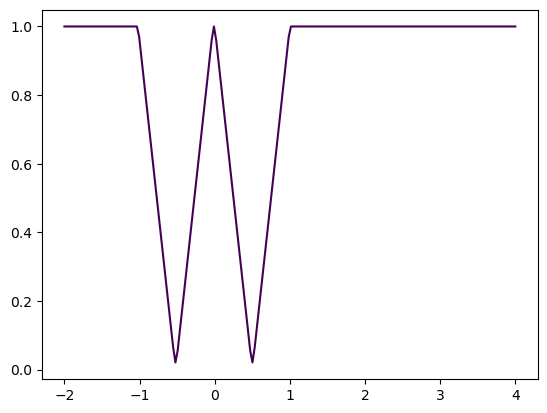

In [25]:
xs_plt = np.linspace(-2,4,200)
plt.plot(xs_plt,test_model([],xs_plt,0))
plt.show()

In [26]:
len(np.unique(times_b))

306

In [27]:
verr = np.zeros((file_b['data'].shape[0],file_b['data'].shape[1]))
vels = np.zeros((file_b['data'].shape[0],file_b['data'].shape[1]))

orders = np.arange(file_b['data'].shape[0],dtype=int)
for order in orders:
    data, _, _ = get_dataset(file_b,[order],cpus[0])
    model_name_b = os.path.join('..','out','24-05-29','barnards_o{}_no_norm.mdl'.format(order))
    model = jabble.model.load(model_name_b)
    
    fischer_info = f_info(model[0][0],model,data)
    # print(fischer_info)
    
    dvddx = jnp.array(
        [jax.grad(jabble.physics.velocities)(x) for x in model[0][0].p]
    )
    verr[order,:] = np.sqrt(1 / fischer_info) * dvddx

    vels[order,:] = jabble.physics.velocities(model[0][0].p)
    

ValueError: too many values to unpack (expected 3)

In [ ]:
def rv_plot(vels,verr,targ_vel,targ_err,mjds,model_name,bervs):
    fig, ax = plt.subplots(
        1,
        figsize=(6, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )

    orders = np.arange(file_b['data'].shape[0],dtype=int)
    for order in orders:
        ev = -(vels[order,:]-bervs)
        ev -= ev.mean()
        ax.plot(mjds,ev,'.k',zorder=1,alpha=0.5,ms=2,label='order {}'.format(order))#$,verr[order,:]
    
    
    tv = targ_vel + bervs
    tv -= tv.mean()
    
    ax.errorbar(
        mjds,
        tv,
        targ_err,
        fmt=".r",
        zorder=1,
        alpha=0.5,
        ms=2,
        label='HARPS RV'
    )
    # print(np.mean(targ_vel),estimate_vel.mean())
    # print(verr.shape,ev.shape)
    
    # fig.legend()
    ax.set_ylim(-1000,1000)
    # ax.set_xlim(-0.5, epoches - 0.5)
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "MJD")
    plt.savefig(os.path.join(out_dir, "02-all-vel.png"))
    plt.show()

In [ ]:
bervs = jnp.array(file_b['bervs'])
rv_plot(vels,verr,targ_vel,targ_err,mjds,model_name_b,bervs)

In [ ]:
lmin = 3800
lmax = 4205
lspace = 20
bervs = jnp.array(file_b['bervs'])
lrange = np.arange(lmin,lmax,lspace)
plt_name = os.path.join(out_dir, "02-{}-spectra.png".format(os.path.split(model_name_b))[-1])
plt_epoches = np.argsort(model_b[0][0].p)
make_bary_plot(model_b,dataset_b,[*plt_epoches[-2:],*plt_epoches[:2]],lmin,lmax,lrange,plt_name,bervs)